In [1]:
def plot_less_data(data):
    import seaborn as sns
    import matplotlib.pyplot as plt
    import numpy as np

    axis_fontsize = 11

    # plot the nominal

    fig, axs = plt.subplots(1, 2, figsize=(11, 5))

    ax = axs[0]
    ax.set_xscale('log', basex=2)

    import matplotlib.ticker
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    data['source_eps'].astype(str)

    red_v = sns.color_palette('Reds', 5)
    blue_v = sns.color_palette('Greens', 5)

    p = {0: sns.xkcd_rgb["grey"],
         3: sns.xkcd_rgb["teal"],
         4: sns.xkcd_rgb["royal blue"]}

    sns.lineplot(x='num_training_images', y='nat_prec1', hue='source_eps', marker='o',
                 data=data, ci=99, ax=ax, palette=p)

#     ax.lines[2].set_linestyle((0,(1,10)))
#     ax.lines[1].set_linestyle(":")
    
    ax.lines[0].set_markeredgecolor(sns.xkcd_rgb["dark grey"])
    
    ax.lines[1].set_marker("^")
    ax.lines[1].set_markeredgecolor(sns.xkcd_rgb["dark blue"])
    
    ax.lines[2].set_marker("s")
    ax.lines[2].set_markeredgecolor(sns.xkcd_rgb["black"])
    

    

    ax.set_xticks(np.sort(data['num_training_images'].unique()))
    ax.set_xlabel('Number of training images (log scale)')
    ax.set_ylabel('Accuracy %')
    # ax.set_title('Accuracy of pre-trained robust and a non-robust model')
    ax.legend(['$\epsilon$= 0.0','$\epsilon$= 3.0', '$\epsilon$= 4.0'], title='Source \nrobustness')
    ax.tick_params(axis='x', labelrotation=45)


    # get the delta

    source_eps_0 = data[data['source_eps'] == 0].sort_values(by=['num_training_images','seed']).reset_index(drop=True)
    source_eps_3 = data[data['source_eps'] == 3].sort_values(by=['num_training_images','seed']).reset_index(drop=True)
    source_eps_4 = data[data['source_eps'] == 4].sort_values(by=['num_training_images','seed']).reset_index(drop=True)

    new_data_1 = source_eps_0.copy()
    new_data_1['nat_prec1_delta'] = source_eps_3['nat_prec1'] - source_eps_0['nat_prec1']
    new_data_1['eps_vs_nat'] = 3

    new_data_2 = source_eps_0.copy()
    new_data_2['nat_prec1_delta'] = source_eps_4['nat_prec1'] - source_eps_0['nat_prec1']
    new_data_2['eps_vs_nat'] = 4

    new_data = pd.DataFrame()
    new_data = new_data.append(new_data_1).append(new_data_2)

    #plot the delta

    import seaborn as sns
    import matplotlib.pyplot as plt

    ax = axs[1]
    ax.set_xscale('log', basex=2)

    import matplotlib.ticker
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

    data['source_eps'].astype(str)
    sns.lineplot(x='num_training_images', y='nat_prec1_delta', hue='eps_vs_nat', marker='o', data=new_data, ci=99, ax=ax, palette=p)


    ax.set_xticks(np.sort(data['num_training_images'].unique()))
    ax.tick_params(axis='x', labelrotation=45)
    ax.set_xlabel('Number of training images (log scale)')
    ax.set_ylabel('Accuracy delta %')
    # ax.set_title('Accuracy delta between a pre-trained robust vs non-robust model')

    #ax.lines[0].set_linestyle("--")
    #ax.lines[1].set_linestyle(":")
    
    ax.lines[0].set_marker("^")
    ax.lines[0].set_markeredgecolor(sns.xkcd_rgb["dark blue"])
    
    ax.lines[1].set_marker("s")
    ax.lines[1].set_markeredgecolor(sns.xkcd_rgb["black"])
    
    ax.legend(['$\epsilon$= 3.0 minus $\epsilon$= 0.0', '$\epsilon$= 4.0 minus $\epsilon$= 0.0'], title='Accuracy delta')


    plt.suptitle('Transfer ResNet50 from ImageNet to CIFAR10 with unfrozen FC layer')

    plt.tight_layout;

In [2]:
import pandas as pd
import pandas as np

# populate df with file_list
df = pd.DataFrame()

file_list = ['CIFAR100.csv', 'CIFAR10_missing_a_few_seeds.csv', 'MNIST.csv', 'SVHN.csv']

for f in file_list:
    df = df.append(pd.read_csv(f))
    
df = df.drop(columns=['Unnamed: 0.1', 'Unnamed: 0'])
df['target_ds'] = df['target_ds'].str.upper()

/home/ubuntu/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [3]:
# BEST VS LAST: Use best (TO BE CONFIRMED)

# make last
by_list = ['target_ds', 'num_training_images', 'seed', 'source_eps', 'unfrozen_blocks'] 
last_df = df.groupby(by=by_list).apply(lambda x: x[x['epoch'] == max(x['epoch'])]).reset_index(drop=True)

# make best
best_df = df.groupby(by=by_list).apply(lambda x: x[x['nat_prec1'] == max(x['nat_prec1'])]).reset_index(drop=True)
inc = by_list + ['nat_prec1']
best_df = best_df.drop_duplicates(subset=inc).reset_index(drop=True)

# check lengths
print(f'length of last: {len(last_df)} \nlength of best: {len(best_df)}')

last_df = last_df.sort_values(by=by_list).reset_index(drop=True)
best_df = best_df.sort_values(by=by_list).reset_index(drop=True)

cols = ['nat_prec1', 'target_ds', 'source_eps', 'unfrozen_blocks', 'num_training_images']

best_minus_last_df = best_df.copy().loc[:, cols]
best_minus_last_df['nat_prec1'] = best_df['nat_prec1'] - last_df['nat_prec1']

cols = ['target_ds', 'source_eps', 'unfrozen_blocks', 'num_training_images']

for col in cols:
    temp_df = pd.DataFrame()
    temp_df = temp_df.append(best_minus_last_df.groupby(by=col).mean().loc[:, ['nat_prec1']])
    temp_df = temp_df.rename(columns={'nat_prec1' : 'mean nat_prec1'})
    temp_df['std nat_prec1'] = best_minus_last_df.groupby(by=col).mean()['nat_prec1']
    display(temp_df)

length of last: 2808 
length of best: 2808


,mean nat_prec1,std nat_prec1
target_ds,,
CIFAR10,0.158438,0.158438
CIFAR100,0.060055,0.060055
MNIST,0.077078,0.077078
SVHN,0.186623,0.186623


,mean nat_prec1,std nat_prec1
source_eps,,
0,0.126689,0.126689
3,0.084910,0.084910
4,0.145674,0.145674


,mean nat_prec1,std nat_prec1
unfrozen_blocks,,
0,0.155856,0.155856
1,0.111824,0.111824
3,0.089593,0.089593


,mean nat_prec1,std nat_prec1
num_training_images,,
100,0.155069,0.155069
200,0.112605,0.112605
400,0.168894,0.168894
800,0.145225,0.145225
1600,0.110557,0.110557
3200,0.098817,0.098817
6400,0.087280,0.087280
12800,0.090481,0.090481
25600,0.041936,0.041936


In [4]:
# pick best_df  or last_df

data = best_df

# get the delta

source_eps_0 = data[data['source_eps'] == 0].sort_values(by=['num_training_images','seed']).reset_index(drop=True)
source_eps_3 = data[data['source_eps'] == 3].sort_values(by=['num_training_images','seed']).reset_index(drop=True)
source_eps_4 = data[data['source_eps'] == 4].sort_values(by=['num_training_images','seed']).reset_index(drop=True)

delta_data = source_eps_0.copy()
delta_data['nat_prec1_delta'] =  source_eps_3['nat_prec1'] - source_eps_4['nat_prec1']

#plot the delta

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np

g = sns.FacetGrid(delta_data, col="unfrozen_blocks", hue="target_ds", margin_titles=True, height=4, sharey=True)
g = g.map(sns.lineplot, "num_training_images", "nat_prec1_delta",  marker='o')
g = g.set_ylabels('Accuracy delta %', fontsize=12)


xticks = np.sort(delta_data[delta_data['target_ds'] == 'MNIST']['num_training_images'].unique())
unfrozen_blocks = np.sort(delta_data[delta_data['target_ds'] == 'MNIST']['unfrozen_blocks'].unique())

for i in range(3):
    ax = g.axes[0][i]
    ax.hlines(y=0, xmin=0, xmax=75000, linestyles='--')
    ax.grid(linestyle=':')
    ax.set_xscale('log', basex=2)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xticks(xticks)
    ax.set_xlabel('')
    ax.set_title(f'Unfrozen blocks = {unfrozen_blocks[i]}')
    ax.tick_params(axis='x', labelrotation=45);
    
g.axes[0][1].set_xlabel('Number of training images (log scale)', fontsize=12)
legend = g.axes[0][2].legend(title='Target dataset', fontsize=10, edgecolor='white')
plt.setp(legend.get_title(),fontsize=12)

g.fig.suptitle(r'Delta in the natural accuracy over the target dataset: $\ell_2$ with $\epsilon=3$ minus $\ell_\infty$ with $\epsilon$=4/255',  y=1.1, fontsize=14);

#plt.tight_layout;

In [5]:
# Cleaning up the number of images for mnist and svhn

import pandas as pd
import pandas as np

target_ds_to_train_set_size = {
    'cifar10' : 50000,
    'cifar100': 50000,
    'mnist'   : 60000,
    'fmnist'  : 60000,
    'kmist'   : 60000,
    'svhn'    : 73257,
}

# populate df with file_list
df = pd.DataFrame()

file_list = ['MNIST.csv', 'SVHN.csv']

for f in file_list:
    temp_df = pd.read_csv(f)
    target_ds = temp_df['target_ds'].unique().tolist()[0]
    train_set_size = target_ds_to_train_set_size[target_ds]
    temp_df = temp_df.replace({'num_training_images' : {50000 : train_set_size}})
    temp_df.to_csv(f)

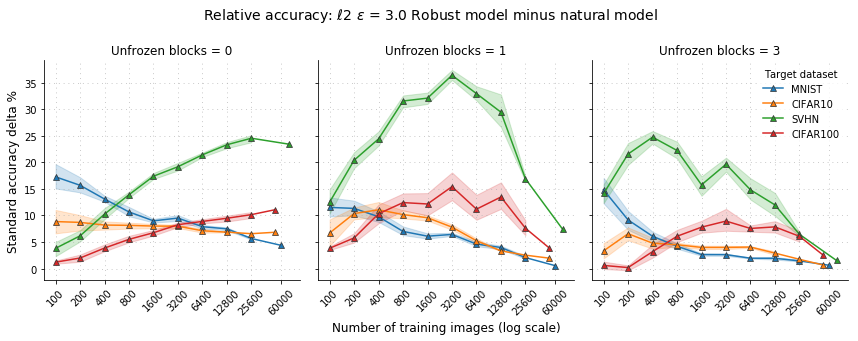

In [253]:
# pick best_df  or last_df

data = best_df

# get the delta

source_eps_0 = data[data['source_eps'] == 0].sort_values(by=['num_training_images','seed']).reset_index(drop=True)
source_eps_3 = data[data['source_eps'] == 3].sort_values(by=['num_training_images','seed']).reset_index(drop=True)
source_eps_4 = data[data['source_eps'] == 4].sort_values(by=['num_training_images','seed']).reset_index(drop=True)

delta_data = source_eps_0.copy()
delta_data['nat_prec1_delta'] =  source_eps_3['nat_prec1'] - source_eps_0['nat_prec1']

#plot the delta

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np

hue_order = ['MNIST', 'CIFAR10', 'SVHN', 'CIFAR100']
grid_linestyle = (0, (1, 5))
p1 = p1 = sns.color_palette(n_colors=4)

g = sns.FacetGrid(delta_data, col="unfrozen_blocks", hue="target_ds", margin_titles=True, height=4, 
                  hue_order=hue_order, sharey=True, palette=p1)
g = g.map(sns.lineplot, "num_training_images", "nat_prec1_delta",  marker='^', markeredgecolor=sns.xkcd_rgb["dark grey"])
g = g.set_ylabels('Standard accuracy delta %', fontsize=12)


xticks = np.sort(delta_data[delta_data['target_ds'] == 'MNIST']['num_training_images'].unique())
unfrozen_blocks = np.sort(delta_data[delta_data['target_ds'] == 'MNIST']['unfrozen_blocks'].unique())

for i in range(3):
    ax = g.axes[0][i]
    ax.grid(linestyle=grid_linestyle)
    ax.set_xscale('log', basex=2)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xticks(xticks)
    ax.set_xlabel('')
    ax.set_title(f'Unfrozen blocks = {unfrozen_blocks[i]}')
    ax.tick_params(axis='x', labelrotation=45);
    
g.axes[0][1].set_xlabel('Number of training images (log scale)', fontsize=12)
legend = g.axes[0][2].legend( title='Target dataset', edgecolor='white')

g.fig.suptitle('Relative accuracy: $\\ell2$ $\\epsilon$ = 3.0 Robust model minus natural model',  y=1.1, fontsize=14);

plt.tight_layout;

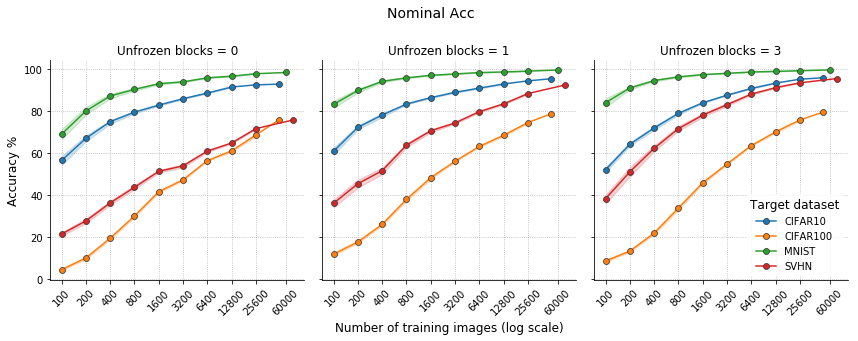

In [240]:
# pick best_df  or last_df

data = best_df

# get the delta

source_eps_3 = data[data['source_eps'] == 3].sort_values(by=['num_training_images','seed']).reset_index(drop=True)

#plot the delta

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np

g = sns.FacetGrid(source_eps_3, col="unfrozen_blocks", hue="target_ds", margin_titles=True, height=4, sharey=True)
g = g.map(sns.lineplot, "num_training_images", "nat_prec1",  marker='o', ci=99, markeredgecolor=sns.xkcd_rgb["dark grey"])
g = g.set_ylabels('Accuracy %', fontsize=12)


xticks = np.sort(source_eps_3[source_eps_3['target_ds'] == 'MNIST']['num_training_images'].unique())
unfrozen_blocks = np.sort(source_eps_3[source_eps_3['target_ds'] == 'MNIST']['unfrozen_blocks'].unique())

for i in range(3):
    ax = g.axes[0][i]
    ax.grid(linestyle=':')
    ax.set_xscale('log', basex=2)
    ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
    ax.set_xticks(xticks)
    ax.set_xlabel('')
    ax.set_title(f'Unfrozen blocks = {unfrozen_blocks[i]}')
    ax.tick_params(axis='x', labelrotation=45);
    
g.axes[0][1].set_xlabel('Number of training images (log scale)', fontsize=12)
legend = g.axes[0][2].legend(title='Target dataset', fontsize=10, edgecolor='white')
plt.setp(legend.get_title(),fontsize=12)

g.fig.suptitle(r'Nominal Acc',  y=1.1, fontsize=14);

#plt.tight_layout;

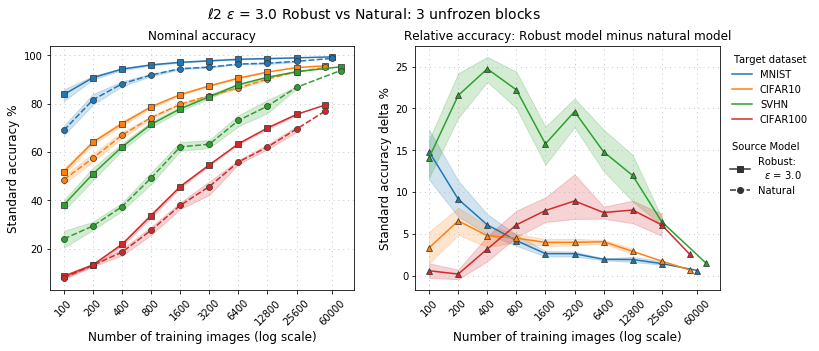

In [254]:
# pick best_df  or last_df

data = best_df

# get the delta

source_eps_3_or_0 = data[((data['source_eps'] == 3) | (data['source_eps'] == 0)) & ((data['unfrozen_blocks'] == 3))].sort_values(by=['num_training_images','seed']).reset_index(drop=True)

#plot the delta

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np

fig, axs = plt.subplots(1,2,figsize=(12,4.5))


ax = axs[0]
p1 = sns.color_palette(n_colors=4)
p2 = sns.color_palette('muted', n_colors=4)

linestyle1= '-'
linestyle2= ':'

grid_linestyle = (0, (1, 5))

hue_order = ['MNIST', 'CIFAR10', 'SVHN', 'CIFAR100']
style_order = [3, 0]
markers = ['s', 'o']
g = sns.lineplot(data=source_eps_3_or_0, x="num_training_images", y='nat_prec1', hue="target_ds", 
                 style='source_eps', hue_order=hue_order, ci=99, ax=ax, markers=markers, palette=p1,
                 style_order=style_order, markeredgecolor=sns.xkcd_rgb["dark grey"])

ax.set_ylabel('Standard accuracy %', fontsize=12)
ax.set_xlabel('Number of training images (log scale)', fontsize=12)
ax.set_xscale('log', basex=2)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks(xticks)
ax.tick_params(axis='x', labelrotation=45)
ax.grid(linestyle=grid_linestyle)
ax.set_title('Nominal accuracy')

leg1 = ax.legend(ax.lines[9:13],  hue_order, title='Target dataset', fontsize=10, edgecolor='white', loc='lower right', bbox_to_anchor=(1,.22))
# leg2 = ax.legend(ax.lines[14:16], ['Robust: $\\epsilon$ = 3', 'Natural'], title='Source Model', fontsize=10, edgecolor='white', loc='lower right')
# ax.add_artist(leg1)
leg2 = ax.legend(ax.lines[14:16], ['Robust: \n  $\\epsilon$ = 3.0', 'Natural'], title='Source Model', fontsize=10, edgecolor='white', 
                 loc='lower right', bbox_to_anchor=(2.5,0.35))


# DELTA CHART

ax = axs[1]
source_eps_0 = data[(data['source_eps'] == 0) & (data['unfrozen_blocks'] == 3)].sort_values(by=['num_training_images','seed']).reset_index(drop=True)
source_eps_3 = data[(data['source_eps'] == 3) & (data['unfrozen_blocks'] == 3)].sort_values(by=['num_training_images','seed']).reset_index(drop=True)

delta_data = source_eps_0.copy()
delta_data['nat_prec1_delta'] =  source_eps_3['nat_prec1'] - source_eps_0['nat_prec1']


g = sns.lineplot(x="num_training_images", y="nat_prec1_delta", data=delta_data, hue="target_ds", 
                 ax=ax, palette=p1, ci=99, marker='^', markeredgecolor=sns.xkcd_rgb["dark grey"],
                 hue_order=hue_order)

ax.set_ylabel('Standard accuracy delta %', fontsize=12)
ax.set_xlabel('Number of training images (log scale)', fontsize=12)
ax.set_xscale('log', basex=2)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks(xticks)
ax.tick_params(axis='x', labelrotation=45)
ax.legend(ax.lines[5:9],hue_order, title='Target dataset', edgecolor='white', bbox_to_anchor=(1.32,1))
ax.grid(linestyle=grid_linestyle)
ax.set_title('Relative accuracy: Robust model minus natural model')

plt.suptitle('$\\ell 2$ $\\epsilon$ = 3.0 Robust vs Natural: 3 unfrozen blocks', fontsize=14, y=1, x=.5)

plt.tight_layout;


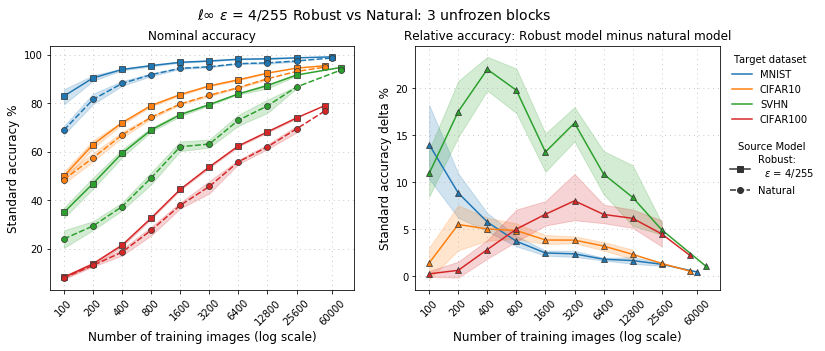

In [255]:
# pick best_df  or last_df

data = best_df

# get the delta

source_eps_3_or_0 = data[((data['source_eps'] == 4) | (data['source_eps'] == 0)) & ((data['unfrozen_blocks'] == 3))].sort_values(by=['num_training_images','seed']).reset_index(drop=True)

#plot the delta

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np

fig, axs = plt.subplots(1,2,figsize=(12,4.5))


ax = axs[0]
p1 = sns.color_palette(n_colors=4)
p2 = sns.color_palette('muted', n_colors=4)

linestyle1= '-'
linestyle2= ':'

grid_linestyle = (0, (1, 5))

hue_order = ['MNIST', 'CIFAR10', 'SVHN', 'CIFAR100']
style_order = [4, 0]
markers = ['s', 'o']
g = sns.lineplot(data=source_eps_3_or_0, x="num_training_images", y='nat_prec1', hue="target_ds", 
                 style='source_eps', hue_order=hue_order, ci=99, ax=ax, markers=markers, palette=p1,
                 style_order=style_order, markeredgecolor=sns.xkcd_rgb["dark grey"])

ax.set_ylabel('Standard accuracy %', fontsize=12)
ax.set_xlabel('Number of training images (log scale)', fontsize=12)
ax.set_xscale('log', basex=2)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks(xticks)
ax.tick_params(axis='x', labelrotation=45)
ax.grid(linestyle=grid_linestyle)
ax.set_title('Nominal accuracy')

leg1 = ax.legend(ax.lines[9:13],  hue_order, title='Target dataset', fontsize=10, edgecolor='white', loc='lower right', bbox_to_anchor=(1,.22))
# leg2 = ax.legend(ax.lines[14:16], ['Robust: $\\epsilon$ = 3', 'Natural'], title='Source Model', fontsize=10, edgecolor='white', loc='lower right')
# ax.add_artist(leg1)
leg2 = ax.legend(ax.lines[14:16], ['Robust: \n  $\\epsilon$ = 4/255', 'Natural'], title='Source Model', fontsize=10, edgecolor='white', 
                 loc='lower right', bbox_to_anchor=(2.54,0.35))


# DELTA CHART

ax = axs[1]
source_eps_0 = data[(data['source_eps'] == 0) & (data['unfrozen_blocks'] == 3)].sort_values(by=['num_training_images','seed']).reset_index(drop=True)
source_eps_3 = data[(data['source_eps'] == 4) & (data['unfrozen_blocks'] == 3)].sort_values(by=['num_training_images','seed']).reset_index(drop=True)

delta_data = source_eps_0.copy()
delta_data['nat_prec1_delta'] =  source_eps_3['nat_prec1'] - source_eps_0['nat_prec1']


g = sns.lineplot(x="num_training_images", y="nat_prec1_delta", data=delta_data, hue="target_ds", 
                 ax=ax, palette=p1, ci=99, marker='^', markeredgecolor=sns.xkcd_rgb["dark grey"],
                 hue_order=hue_order)

ax.set_ylabel('Standard accuracy delta %', fontsize=12)
ax.set_xlabel('Number of training images (log scale)', fontsize=12)
ax.set_xscale('log', basex=2)
ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())
ax.set_xticks(xticks)
ax.tick_params(axis='x', labelrotation=45)
ax.legend(ax.lines[5:9],hue_order, title='Target dataset', edgecolor='white', bbox_to_anchor=(1.32,1))
ax.grid(linestyle=grid_linestyle)
ax.set_title('Relative accuracy: Robust model minus natural model')

plt.suptitle('$\\ell\infty$ $\\epsilon$ = 4/255 Robust vs Natural: 3 unfrozen blocks', fontsize=14, y=1, x=.5)

plt.tight_layout;


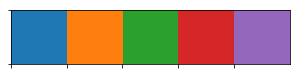

In [91]:
sns.palplot(sns.color_palette(n_colors=n))

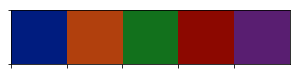

In [92]:
sns.palplot(sns.color_palette('dark', n_colors=n))

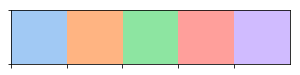

In [93]:
sns.palplot(sns.color_palette('pastel', n_colors=n))

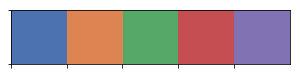

In [94]:
sns.palplot(sns.color_palette('deep', n_colors=n))

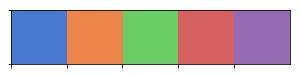

In [95]:
sns.palplot(sns.color_palette('muted', n_colors=n))

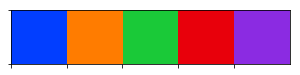

In [96]:
sns.palplot(sns.color_palette('bright', n_colors=n))